In [4]:
# Set all dependency and variable

# %load_ext tensorboard
import datetime
import numpy as np
import seaborn as sn
import pandas as pd
import sklearn.metrics
import matplotlib.pyplot as plt

import tensorflow as tf
import keras_preprocessing

from tensorflow.python.client import device_lib 
from tensorflow.keras import utils, layers, backend

from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

from skimage import exposure
from skimage import filters


print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9909004139526340335
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 949175060207319333
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1391427175
locality {
  bus_id: 1
  links {
  }
}
incarnation: 172823480385937721
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 16001486876132934263
physical_device_desc: "device: XLA_GPU device"
]


In [5]:
# Check number of CPU and GPU that Tensorflow used\

print("Num CPUUs Available: ", len(tf.config.list_physical_devices('CPU')))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num CPUUs Available:  1
Num GPUs Available:  1


In [6]:
IMAGE_SIZE = 224
BATCH_SIZE = 8

IMAGE_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

In [7]:
datagen = ImageDataGenerator(
#     rescale = 1./127.5,
    rescale = 1./255. ,
    rotation_range=45,
    # featurewise_center=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
#     zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
#     preprocessing_function = preprocess,
    validation_split=0.25,
)

test_generator = ImageDataGenerator(
    rescale = 1./255. ,
    validation_split=0.25,
)


In [8]:
TRAINING_DIR = "dataset"
VALIDATION_DIR = "validation"
TEST_DIR = "dataset_kue_test_2"

print("Loading training data...\t\t", end='')
train_generator = datagen.flow_from_directory(
	  TRAINING_DIR,
  	target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='training',
    class_mode='categorical',
    shuffle=True,
)

print("Loading validation data...\t\t", end='')
validation_generator = test_generator.flow_from_directory(
  	 TRAINING_DIR,
#     VALIDATION_DIR,
	  target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation',
    class_mode='categorical',
    shuffle=True,
)

print("Loading testing data...\t\t", end='')
test_data = test_generator.flow_from_directory(
    TEST_DIR,
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
)

Loading training data...		Found 638 images belonging to 8 classes.
Loading validation data...		Found 207 images belonging to 8 classes.
Loading testing data...		Found 160 images belonging to 8 classes.


In [9]:
# train_images_7, train_labels_7 = train_generator[5]
# print(train_images_7.shape)
# print(train_labels_7.shape)

# plt.figure(figsize=(20, 20))

# for idx in range(16):
#     ax = plt.subplot(2, 4, idx + 1)
#     plt.imshow(keras_preprocessing.image.array_to_img(train_images_7[idx]))
#     plt.title(str(train_labels_7[idx]))
#     plt.axis('off')

# plt.show

In [10]:
class_names = []
for a in train_generator.class_indices:
    class_names.append(a)
print(class_names)

['kue_cenil', 'kue_clorot', 'kue_dadar_gulung', 'kue_klepon', 'kue_lapis', 'kue_lumpur', 'kue_mendut', 'kue_serabi']


In [11]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((8, 224, 224, 3), (8, 8))

In [12]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'kue_cenil': 0, 'kue_clorot': 1, 'kue_dadar_gulung': 2, 'kue_klepon': 3, 'kue_lapis': 4, 'kue_lumpur': 5, 'kue_mendut': 6, 'kue_serabi': 7}


In [13]:
base_model = tf.keras.applications.MobileNetV2(
    IMAGE_SHAPE,
    include_top=False,
    weights='imagenet',
)
base_model.trainable = False
# base_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
mobilenetv2_1.00_224 (Functiona (None, 7, 7, 1280)   2257984     input_2[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 1280)         0           mobilenetv2_1.00_224[0][0]       
__________________________________________________________________________________________________
global_max_pooling2d (GlobalMax (None, 1280)         0           mobilenetv2_1.00_224[0][0]       
_______________________________________________________________________________________

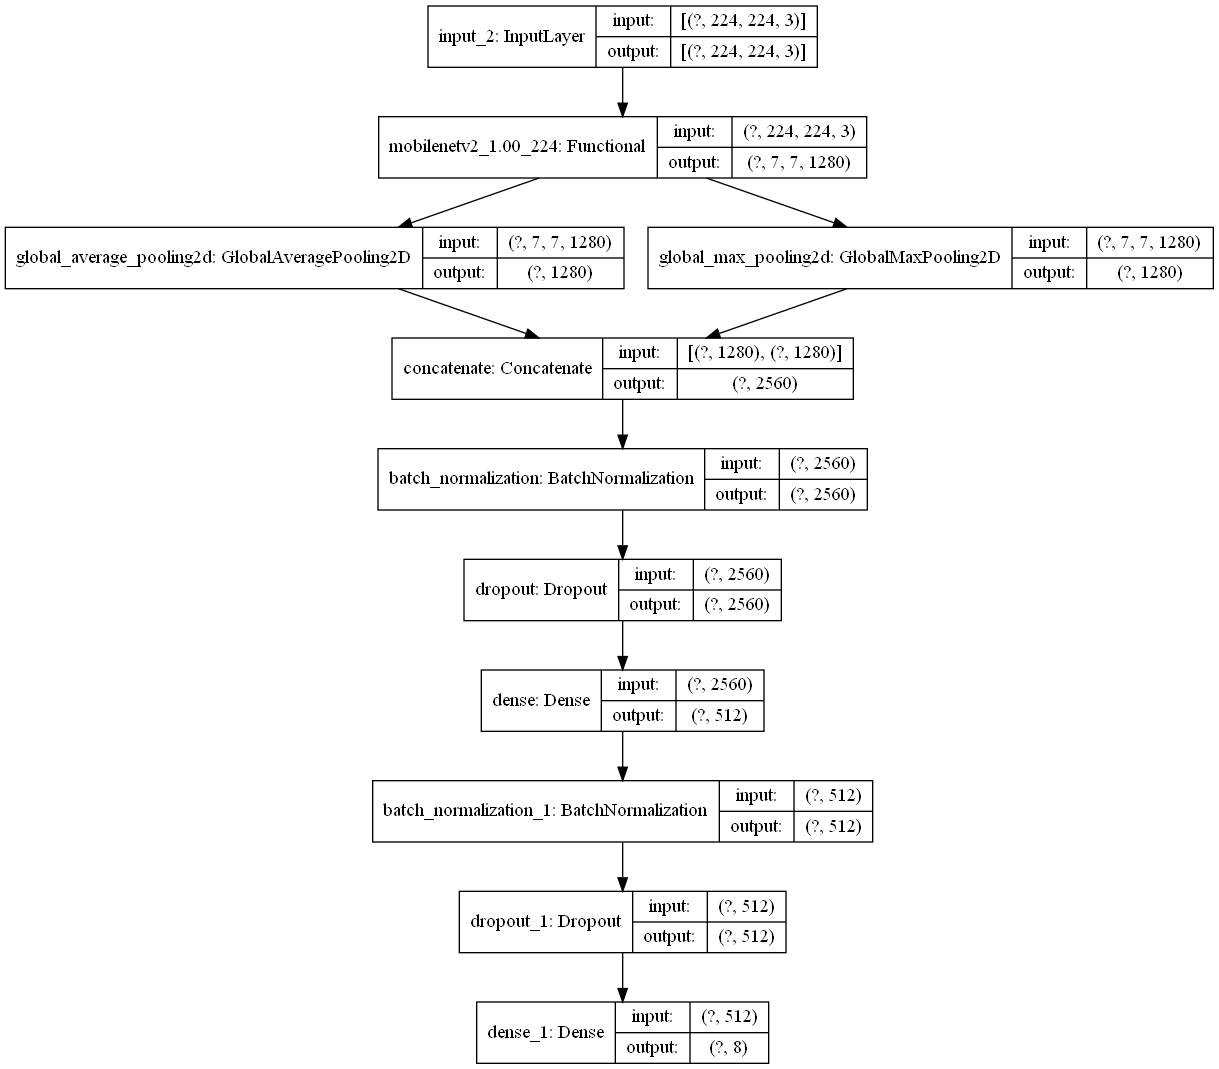

In [14]:
input_layer = tf.keras.Input(shape=IMAGE_SHAPE)
# x = tf.keras.applications.mobilenet_v2.preprocess_input(input_layer)
x = base_model(input_layer, training=False)

#keras
# x = layers.GlobalAveragePooling2D()(x)

#fastai
x1 = layers.GlobalAveragePooling2D()(x)
x2 = layers.GlobalMaxPooling2D()(x)
x = layers.Concatenate()([x1, x2])
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

#sazzad
# x = layers.GlobalAveragePooling2D()(x)
# x = layers.Dropout(0.5)(x)
# x = layers.Dense(1024, activation="relu")(x)
# x = layers.Dropout(0.5)(x)

#bimo
# x = layers.GlobalMaxPooling2D()(x)
# x = layers.Dense(1024, activation="relu")(x)
# x = layers.Dropout(0.2)(x)
# x = layers.Dense(128, activation="relu")(x)
# x = layers.Dropout(0.2)(x)

output_layer = layers.Dense(train_generator.num_classes, activation="softmax")(x)

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

l_rate = 0.0001
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=l_rate), metrics=['accuracy'])

model.summary()
utils.plot_model(model, show_layer_names=True, show_shapes=True)

In [15]:
# Train the data

# %tensorboard --logdir logs
n_epoch = 10
# es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# history = data_prep.fit(train_generator,
#                     steps_per_epoch=len(train_generator), 
# #                     steps_per_epoch=100, 
#                     epochs=10, 
#                     validation_data = validation_generator, 
#                     validation_steps=len(validation_generator),
# #                     validation_steps=100,
# #                     batch_size=32,
#                     # verbose=1,
#                     # callbacks=[es_callback],
# #                     callbacks=[cm_callback],
#                     )

history = model.fit(train_generator,
                    epochs=n_epoch, 
                    validation_data = validation_generator, 
                    verbose=1,
                    # callbacks=[es_callback],
#                     callbacks=[cm_callback],
                    )

Epoch 1/10
80/80 [==============================] - 24s 294ms/step - loss: 2.2173 - accuracy: 0.3495 - val_loss: 0.7461 - val_accuracy: 0.7729
Epoch 2/10
80/80 [==============================] - 22s 279ms/step - loss: 1.1275 - accuracy: 0.6379 - val_loss: 0.3313 - val_accuracy: 0.9082
Epoch 3/10
80/80 [==============================] - 22s 278ms/step - loss: 0.9027 - accuracy: 0.6865 - val_loss: 0.2298 - val_accuracy: 0.9372
Epoch 4/10
80/80 [==============================] - 20s 254ms/step - loss: 0.6504 - accuracy: 0.7649 - val_loss: 0.1928 - val_accuracy: 0.9469
Epoch 5/10
80/80 [==============================] - 21s 261ms/step - loss: 0.6127 - accuracy: 0.8025 - val_loss: 0.1737 - val_accuracy: 0.9614
Epoch 6/10
80/80 [==============================] - 20s 253ms/step - loss: 0.5434 - accuracy: 0.8323 - val_loss: 0.1557 - val_accuracy: 0.9517
Epoch 7/10
80/80 [==============================] - 20s 249ms/step - loss: 0.5036 - accuracy: 0.8417 - val_loss: 0.1709 - val_accuracy: 0.9517

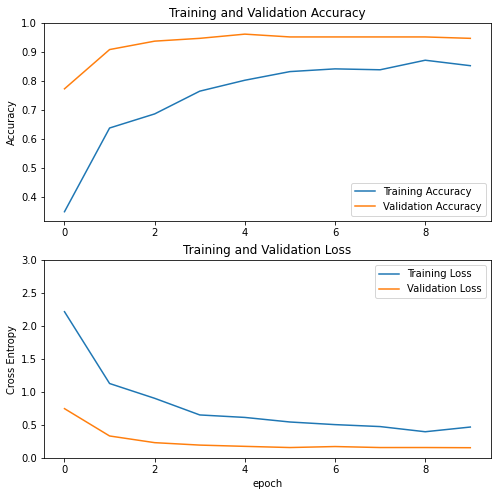

In [16]:
# Graph

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [17]:
print("Model evaluate:")
results = model.evaluate(test_data)

Model evaluate:
20/20 [==============================] - 1s 66ms/step - loss: 0.1336 - accuracy: 0.9500


In [18]:
# from sklearn.metrics import classification_report, confusion_matrix
# from mlxtend.plotting import plot_confusion_matrix

# pred = model.predict(test_data)
# y_pred = tf.argmax(pred, 1) 
# plot_conf = confusion_matrix(test_data.classes, y_pred)
# plot_confusion_matrix(conf_mat=plot_conf)
# # prediction=tf.argmax(y,1)

# # res = tf.math.confusion_matrix(prediction,pred)
# # print('Confusion_matrix: ',res)

Confusion Matrix
[[5 2 4 1 5 0 2 1]
 [3 1 2 0 5 3 3 3]
 [2 4 2 3 2 1 2 4]
 [0 3 1 2 2 3 2 7]
 [1 2 3 6 2 4 1 1]
 [1 3 2 4 1 3 5 1]
 [2 1 2 2 4 4 3 2]
 [1 3 4 4 1 2 2 3]]


<AxesSubplot:>

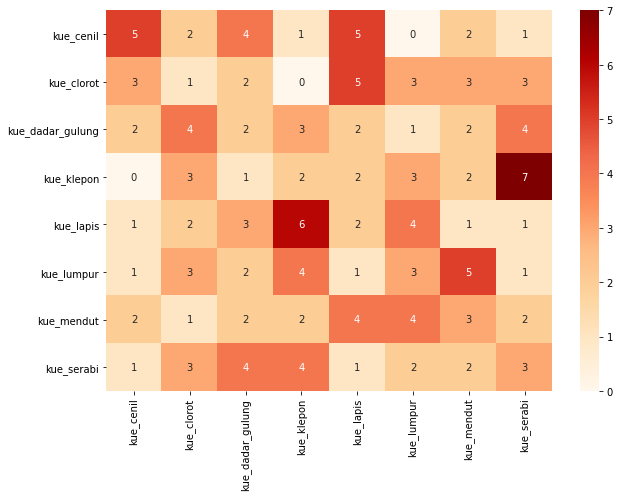

In [29]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict(test_data)
y_pred = tf.argmax(Y_pred, 1) 
conn = confusion_matrix(test_data.classes, y_pred)
print('Confusion Matrix')
print(conn)
df_cm = pd.DataFrame(conn, index = class_names,
                  columns = class_names)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="OrRd")

Confusion Matrix
[[1 4 4 1 2 4 2 2]
 [1 2 4 1 2 3 5 2]
 [3 2 0 6 4 1 1 3]
 [0 3 3 3 3 4 1 3]
 [1 2 2 5 4 2 1 3]
 [2 2 2 1 2 2 5 4]
 [2 3 1 3 2 2 2 5]
 [5 1 4 2 3 2 3 0]]


<AxesSubplot:>

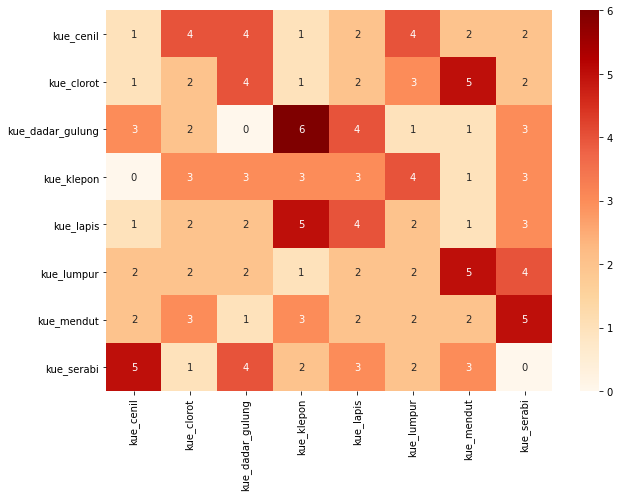

In [43]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1) 
conn = confusion_matrix(test_data.classes, y_pred)
print('Confusion Matrix')
print(conn)
df_cm = pd.DataFrame(conn, index = class_names,
                  columns = class_names)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="OrRd")

Confusion Matrix
[[2 3 2 3 2 3 3 2]
 [1 3 2 3 4 1 2 4]
 [2 2 1 5 3 2 1 4]
 [1 4 1 2 4 2 3 3]
 [1 0 6 2 3 2 4 2]
 [2 3 4 3 1 3 3 1]
 [1 2 2 2 5 4 1 3]
 [5 2 2 2 0 3 3 3]]


<AxesSubplot:>

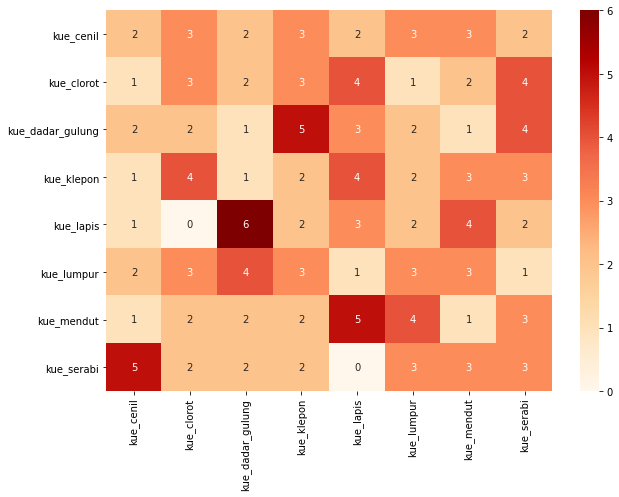

In [37]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1) 
conn = confusion_matrix(test_data.classes, y_pred)
print('Confusion Matrix')
print(conn)
df_cm = pd.DataFrame(conn, index = class_names,
                  columns = class_names)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="OrRd")

Confusion Matrix
[[2 2 3 3 4 2 2 2]
 [1 2 2 3 5 2 4 1]
 [1 3 3 1 5 3 0 4]
 [2 2 2 5 0 5 2 2]
 [3 5 2 0 2 2 3 3]
 [1 2 3 3 2 3 4 2]
 [3 1 4 3 2 1 4 2]
 [2 2 1 4 2 2 1 6]]


<AxesSubplot:>

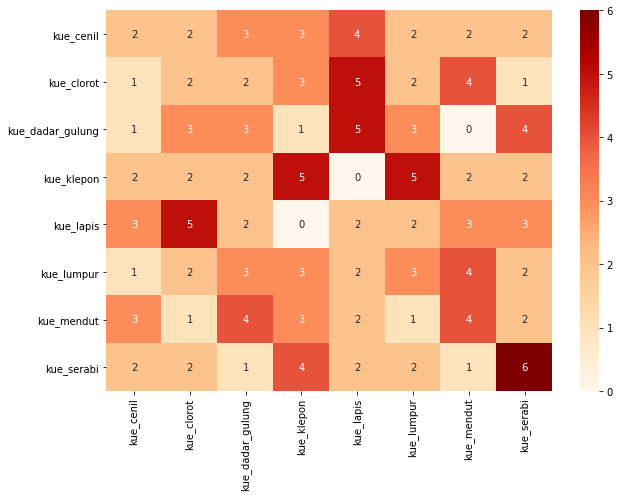

In [41]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict(test_data,  BATCH_SIZE // BATCH_SIZE+1)
y_pred = np.argmax(Y_pred, axis=1) 
conn = confusion_matrix(test_data.classes, y_pred)
print('Confusion Matrix')
print(conn)
df_cm = pd.DataFrame(conn, index = class_names,
                  columns = class_names)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="OrRd")

Confusion Matrix
[[3 3 3 1 2 2 3 3]
 [2 2 1 3 4 4 0 4]
 [0 4 4 3 1 1 5 2]
 [2 2 2 5 3 3 3 0]
 [4 1 1 6 3 3 1 1]
 [2 1 2 1 2 4 4 4]
 [2 2 3 1 4 2 4 2]
 [0 4 4 2 3 1 0 6]]


<AxesSubplot:>

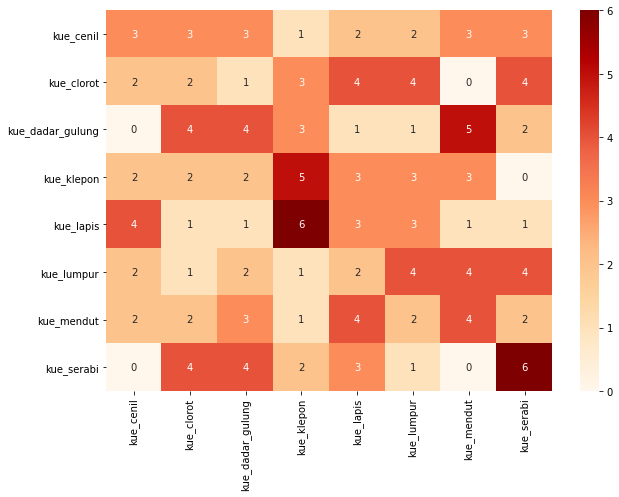

In [42]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1) 
conn = confusion_matrix(test_data.classes, y_pred)
print('Confusion Matrix')
print(conn)
df_cm = pd.DataFrame(conn, index = class_names,
                  columns = class_names)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="OrRd")

IndexError: index 8 is out of bounds for axis 0 with size 8

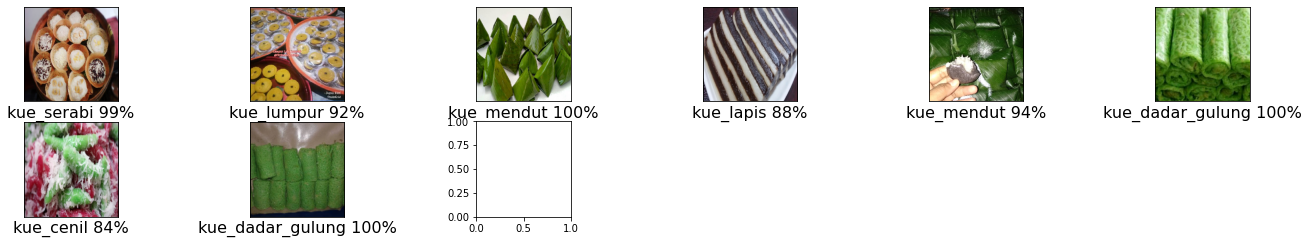

In [47]:
num_rows = 3
num_cols = 6
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))


def plot_image(i, predictions_array, true_label, img, target):
  true_label, img = true_label[i], img[i]
  wh = np.where(true_label)
  npa = np.int64(wh[0]).astype(int)

  predicted_label = np.argmax(predictions_array)


  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)
  plt.xlabel("{} {:2.0f}%".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                ),
             fontsize=16,
             )

target = 7
x, y = test_data.next()
for i in range(64):
  predictions = model.predict(x)
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], y, x, target)

plt.tight_layout()
plt.show()


IndexError: index 8 is out of bounds for axis 0 with size 8

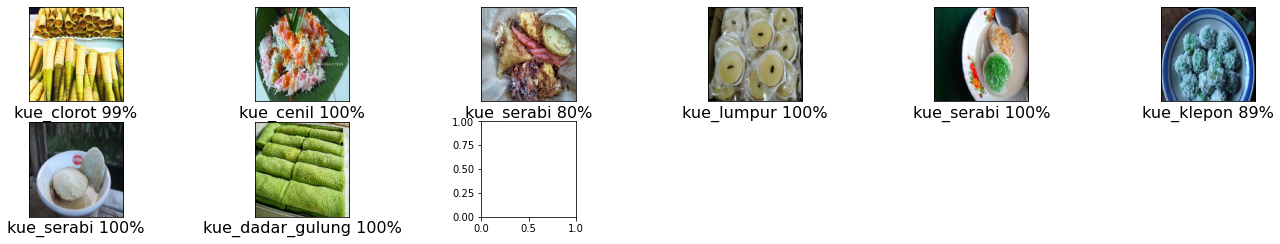

In [50]:
num_rows = 3
num_cols = 6
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))


def plot_image(i, predictions_array, true_label, img, target):
  true_label, img = true_label[i], img[i]
  wh = np.where(true_label)
  npa = np.int64(wh[0]).astype(int)

  predicted_label = np.argmax(predictions_array)


  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)
  plt.xlabel("{} {:2.0f}%".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                ),
             fontsize=16,
             )

target = 7
x, y = test_data.next()
for i in range(64):
  predictions = model.predict(x)
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], y, x, target)

plt.tight_layout()
plt.show()

In [45]:
saved_model_dir = 'model_final'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('model/28-4-21-p2/model.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model_final\assets
